# Predicción con Redes Neuronales

* Diego Elián Rodríguez Cantú A00829925
* Oscar Antonio Banderas Álvarez A01568492
* Taurino López González A01284076
* Ivan Karlo González Barreda A01025331
* Axel Antonio Maldonado Del Bosque A00830422
* Elias Garza Valdés A01284041

In [57]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

## Carga de datos

In [35]:
data = pd.read_csv("TablaReservaciones_Reto.csv")
data.head()

C:\Users\elian.rodriguez\AppData\Local\Temp\ipykernel_7296\1136145674.py:1: DtypeWarning: Columns (22,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("TablaReservaciones_Reto.csv")


,ID_Reserva,Fecha_hoy,h_res_fec,h_res_fec_ok,h_res_fec_okt,h_num_per,aa_h_num_per,h_num_adu,aa_h_num_adu,h_num_men,aa_h_num_men,h_num_noc,aa_h_num_noc,h_tot_hab,aa_h_tot_hab,ID_Programa,ID_Paquete,ID_Segmento_Comp,ID_Agencia,ID_empresa,ID_Tipo_Habitacion,ID_canal,h_fec_lld,h_fec_lld_ok,h_fec_lld_okt,h_fec_reg,h_fec_reg_ok,h_fec_reg_okt,h_fec_sda,h_fec_sda_ok,h_fec_sda_okt,ID_Pais_Origen,Cliente_Disp,aa_Cliente_Disp,Reservacion,aa_Reservacion,ID_estatus_reservaciones,h_can_res,h_cod_reserva,h_edo,h_codigop,h_correo_e,h_nom,h_tfa_total,aa_h_tfa_total,moneda_cve,h_ult_cam_fec,h_ult_cam_fec_ok,h_ult_cam_fec_okt
0,0,2019-08-16 00:00:00.000,20190816,2019-08-16,2019-08-16 00:00:00.000,2,0,2,0,0,0,3,0,1,0,1,1,14,112,1,25,10,20191107,2019-11-07,2019-11-07 00:00:00.000,20190816,2019-08-16,2019-08-16 00:00:00.000,20191110,2019-11-10,2019-11-10 00:00:00.000,157,2,0,1,0,9,09,,EMX,01500,TOSC55@HOTMAIL.COM ...,"QUIROZ, SOFIA",2659.98,0.0,1,20191110,2019-11-10,2019-11-10 00:00:00.000
1,1,2019-10-22 00:00:00.000,20191022,2019-10-22,2019-10-22 00:00:00.000,4,0,4,0,0,0,4,0,1,0,1,2,14,112,1,25,10,20191201,2019-12-01,2019-12-01 00:00:00.000,20191022,2019-10-22,2019-10-22 00:00:00.000,20191205,2019-12-05,2019-12-05 00:00:00.000,157,4,0,1,0,9,09,,EGT,023541,125@HOTMAIL.COM ...,"JIMENEZ, VALENTIN",1764.00,0.0,1,20191205,2019-12-05,2019-12-05 00:00:00.000
2,2,2019-10-28 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,2,0,2,0,0,0,4,0,1,0,1,1,14,112,1,23,10,20191201,2019-12-01,2019-12-01 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,20191205,2019-12-05,2019-12-05 00:00:00.000,157,2,0,1,0,9,09,,EMC,59800,123@HOTMAIL.COM ...,"GALLEGOS, JORGE ROBERTO",2660.04,0.0,1,20191205,2019-12-05,2019-12-05 00:00:00.000
3,3,2019-10-28 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,4,0,3,0,0,0,3,0,1,0,1,2,14,112,1,24,10,20191208,2019-12-08,2019-12-08 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,20191211,2019-12-11,2019-12-11 00:00:00.000,157,3,0,1,0,9,09,,EGT,37219,checotl71@gmail.com ...,"PEREA, VICTOR HUGO",1995.03,0.0,1,20191211,2019-12-11,2019-12-11 00:00:00.000
4,4,2019-10-28 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,2,0,2,0,0,0,4,0,1,0,1,1,5,14,1,4,13,20191208,2019-12-08,2019-12-08 00:00:00.000,20191208,2019-12-08,2019-12-08 00:00:00.000,20191212,2019-12-12,2019-12-12 00:00:00.000,157,2,0,1,0,9,12,74101652-3_2394,EMX,15300,REVINATE@AZULIXTAPA.COM.MX ...,"TREJO GALVAN, RAMON",13369.92,0.0,1,20191212,2019-12-12,2019-12-12 00:00:00.000


## Preparacion de datos


In [36]:
# Agrupando y contando reservas por día
data['h_res_fec'] = pd.to_datetime(data['h_res_fec'], format='%Y%m%d')
data.set_index('h_res_fec', inplace=True)  # Usamos la fecha de reserva como índice

In [37]:
# Sumar el número de personas reservadas por día
daily_reservations = data['h_num_per'].resample('D').sum()
daily_reservations = daily_reservations.reset_index()

In [41]:
scaler = MinMaxScaler(feature_range=(0, 1))
daily_reservations['h_num_per_scaled'] = scaler.fit_transform(daily_reservations[['h_num_per']])

## Preparacion de la entrada para LSTM [sample, time step, features]

In [49]:
# Función para crear secuencias de datos
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 3  # Usar 3 días pasados para predecir el siguiente
X, y = create_dataset(daily_reservations['h_num_per_scaled'].values, look_back)

# Cambiar el formato de entrada a [muestras, pasos de tiempo, características]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Dividir datos en entrenamiento y prueba
train_size = int(len(X) * 0.70)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Construcción del modelo

In [50]:
# Construcción del modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\elian.rodriguez\tarea_otero\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Entrenamiento

In [51]:
# Entrenamiento del modelo
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
336/336 - 1s - 3ms/step - loss: 0.0157
Epoch 2/50
336/336 - 0s - 744us/step - loss: 0.0151
Epoch 3/50
336/336 - 0s - 743us/step - loss: 0.0149
Epoch 4/50
336/336 - 0s - 938us/step - loss: 0.0147
Epoch 5/50
336/336 - 0s - 744us/step - loss: 0.0147
Epoch 6/50
336/336 - 0s - 743us/step - loss: 0.0148
Epoch 7/50
336/336 - 0s - 756us/step - loss: 0.0146
Epoch 8/50
336/336 - 0s - 794us/step - loss: 0.0146
Epoch 9/50
336/336 - 0s - 750us/step - loss: 0.0147
Epoch 10/50
336/336 - 0s - 838us/step - loss: 0.0144
Epoch 11/50
336/336 - 0s - 738us/step - loss: 0.0142
Epoch 12/50
336/336 - 0s - 801us/step - loss: 0.0144
Epoch 13/50
336/336 - 0s - 787us/step - loss: 0.0145
Epoch 14/50
336/336 - 0s - 794us/step - loss: 0.0143
Epoch 15/50
336/336 - 0s - 784us/step - loss: 0.0143
Epoch 16/50
336/336 - 0s - 743us/step - loss: 0.0143
Epoch 17/50
336/336 - 0s - 793us/step - loss: 0.0143
Epoch 18/50
336/336 - 0s - 758us/step - loss: 0.0139
Epoch 19/50
336/336 - 0s - 795us/step - loss: 0.0141
Epoc

## Predicciones

In [52]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir la escala de las predicciones
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


## Resultados

Train Score: 420.64 RMSE
Test Score: 369.67 RMSE


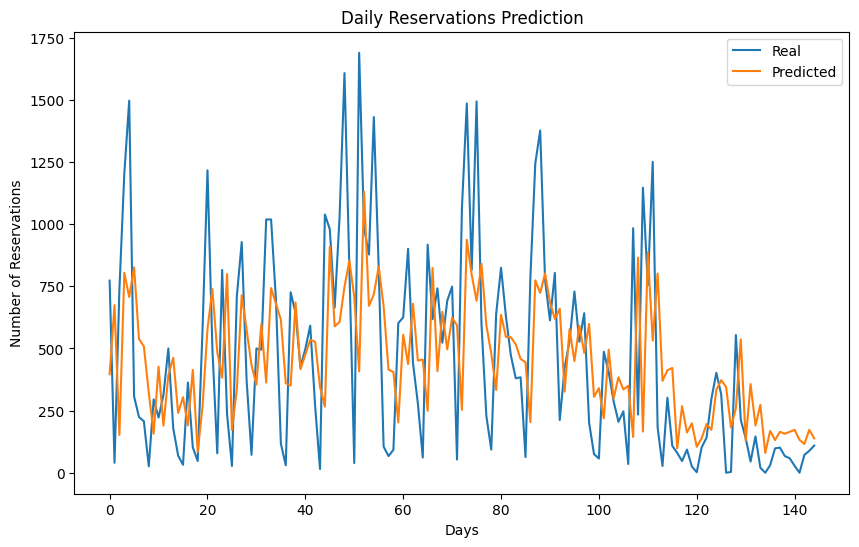

In [53]:
# Calcular RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_inv[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))
print('Train Score: {:.2f} RMSE'.format(train_rmse))
print('Test Score: {:.2f} RMSE'.format(test_rmse))

# Plot de resultados
plt.figure(figsize=(10,6))
plt.plot(y_test_inv[0], label='Real')
plt.plot(test_predict[:,0], label='Predicted')
plt.title('Daily Reservations Prediction')
plt.xlabel('Days')
plt.ylabel('Number of Reservations')
plt.legend()
plt.show()

## Extrapolacion

In [54]:
last_input = daily_reservations['h_num_per_scaled'].values[-look_back:]
last_input = np.reshape(last_input, (1, look_back, 1))

In [55]:
# Número de pasos en el futuro
n_future = 10
future_predictions = []

# Usar el modelo para hacer predicciones hacia el futuro
for _ in range(n_future):
    prediction = model.predict(last_input)[0]  # Realiza una predicción basada en la última entrada
    future_predictions.append(prediction)  # Guardar la predicción
    
    # Actualizar la última entrada para incluir la nueva predicción
    last_input = np.append(last_input[:,1:,:], [[prediction]], axis=1)

# Convertir predicciones a escala original
future_predictions = scaler.inverse_transform(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


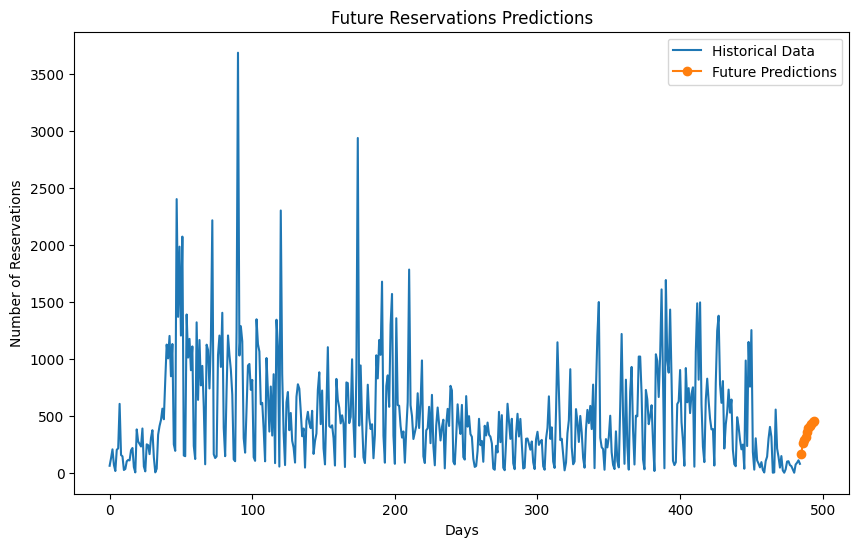

In [56]:
# Visualizar las predicciones futuras
plt.figure(figsize=(10,6))
plt.plot(range(len(daily_reservations)), scaler.inverse_transform(daily_reservations['h_num_per_scaled'].values.reshape(-1,1)), label='Historical Data')
plt.plot(range(len(daily_reservations), len(daily_reservations) + n_future), future_predictions, marker='o', label='Future Predictions')
plt.title('Future Reservations Predictions')
plt.xlabel('Days')
plt.ylabel('Number of Reservations')
plt.legend()
plt.show()